In [6]:
import torch
import torchvision

import matplotlib.pyplot as plt

# interactive mode
plt.ion()

import train_helper

# autoreload external code
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
dataloaders, class_names = train_helper.load_data()

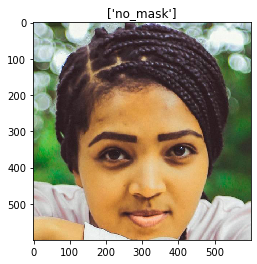

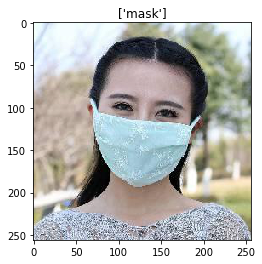

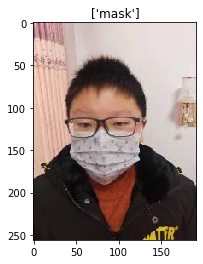

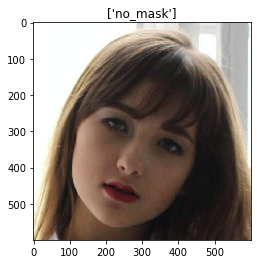

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

for _ in range(4):
    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])

In [4]:
# train a new model
n_epochs = 30
model, criterion, optimizer, scheduler = train_helper.get_model(dataloaders, n_epochs)
model = train_helper.train_model(model, criterion, optimizer, scheduler, dataloaders, n_epochs=n_epochs)

In [8]:
# load an existing model from disk
model = train_helper.load_model('model.pt', map_location=device)

/opt/anaconda3/envs/csm-face-mask-2/lib/python3.8/site-packages/torch/serialization.py:579: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


In [16]:
def visualize_model(model, device, dataloaders, num_images=19):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


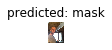

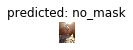

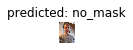

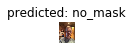

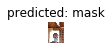

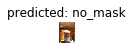

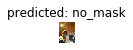

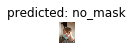

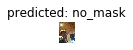

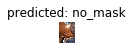

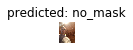

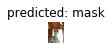

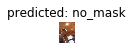

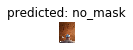

KeyboardInterrupt: 

In [17]:
visualize_model(model, device, dataloaders)